# Análise do Roberto

In [ ]:
pip uninstall numpy pandas statsmodels scikit-learn -y

In [ ]:
pip install numpy==1.21.6


In [ ]:
pip install --upgrade pandas==1.3.5

In [ ]:
pip install --upgrade statsmodels==0.13.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick

In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df_mensal = pd.read_excel('../data/faturamento.xlsx', sheet_name='Mes', header=None)
df_mensal.columns = ['data', 'faturamento']
df_mensal['data'] = pd.to_datetime(df_mensal['data'])

In [4]:
df = df_mensal.set_index('data')

In [5]:
train = df[:'2024-06-01']
val = df['2024-07-01':'2025-03-01']
test = df['2025-04-01':]

In [6]:
print("📊 Dados carregados:")
print(f"Período: {df.index.min().strftime('%b/%Y')} a {df.index.max().strftime('%b/%Y')}")
print(f"Total de meses: {len(df)}")
print(f"Shape: {df.shape}")
print("\nPrimeiras linhas:")
print(df.head())


📊 Dados carregados:
Período: Jan/2023 a Sep/2025
Total de meses: 33
Shape: (33, 1)

Primeiras linhas:
             faturamento
data                    
2023-01-01  2.106273e+06
2023-02-01  2.345394e+06
2023-03-01  3.632425e+06
2023-04-01  2.789569e+06
2023-05-01  2.566891e+06


In [7]:
print("Tamanho total:", df.shape)
print("Treino:", train.shape)
print("Validação:", val.shape)
print("Teste :", test.shape)

Tamanho total: (33, 1)
Treino: (18, 1)
Validação: (9, 1)
Teste : (6, 1)


Analise Exploratória dos Dados

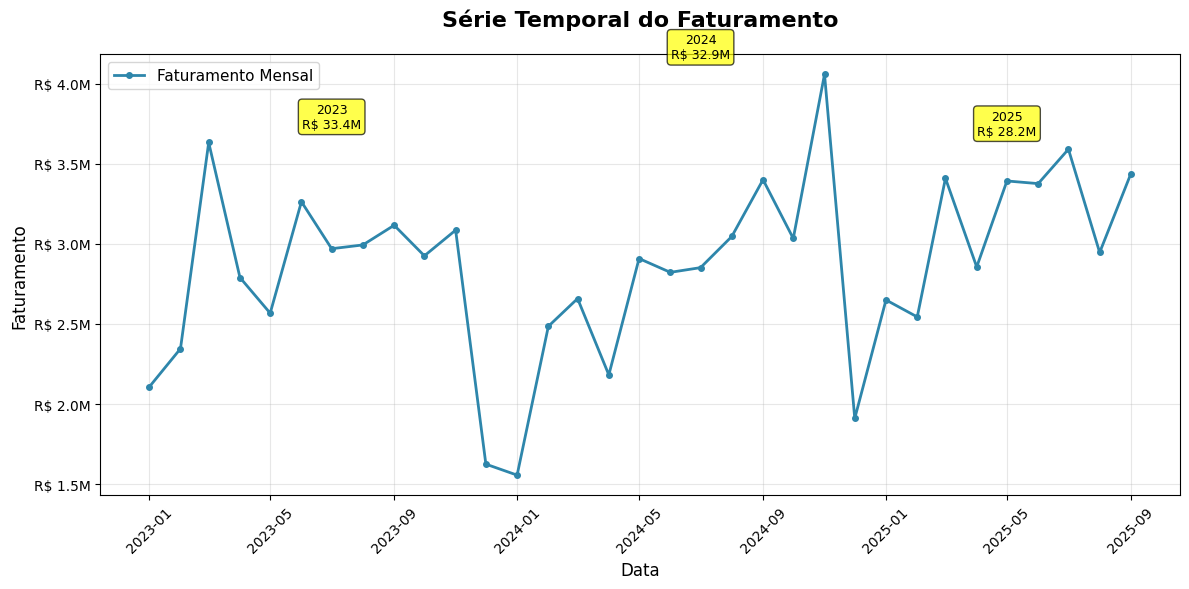

In [8]:
df_fat = df_mensal
df_fat = df_fat.sort_values('data')
df_fat.set_index('data', inplace=True)


plt.figure(figsize=(12, 6))

ax = plt.subplot(1, 1, 1)
plt.plot(df_fat.index, df_fat['faturamento'], marker='o', linewidth=2, markersize=4,
         label='Faturamento Mensal', color='#2E86AB')


def format_reais(x, pos):
    if x >= 1e6:
        return f'R$ {x/1e6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x/1e3:.0f}K'
    else:
        return f'R$ {x:.0f}'


ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_reais))

plt.title('Série Temporal do Faturamento', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Faturamento', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)


anos = df_fat.index.year.unique()
for ano in anos:
    dados_ano = df_fat[df_fat.index.year == ano]
    if len(dados_ano) > 0:
        faturamento_anual = dados_ano['faturamento'].sum()
        plt.text(dados_ano.index[len(dados_ano)//2], dados_ano['faturamento'].max() * 1.02,
                 f'{ano}\nR$ {faturamento_anual/1e6:.1f}M',
                 ha='center', va='bottom', fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

In [9]:
print(df_mensal.describe())

                                data   faturamento
count                             33  3.300000e+01
mean   2024-05-01 10:10:54.545454592  2.864416e+06
min              2023-01-01 00:00:00  1.556058e+06
25%              2023-09-01 00:00:00  2.566891e+06
50%              2024-05-01 00:00:00  2.924932e+06
75%              2025-01-01 00:00:00  3.262739e+06
max              2025-09-01 00:00:00  4.057955e+06
std                              NaN  5.664653e+05


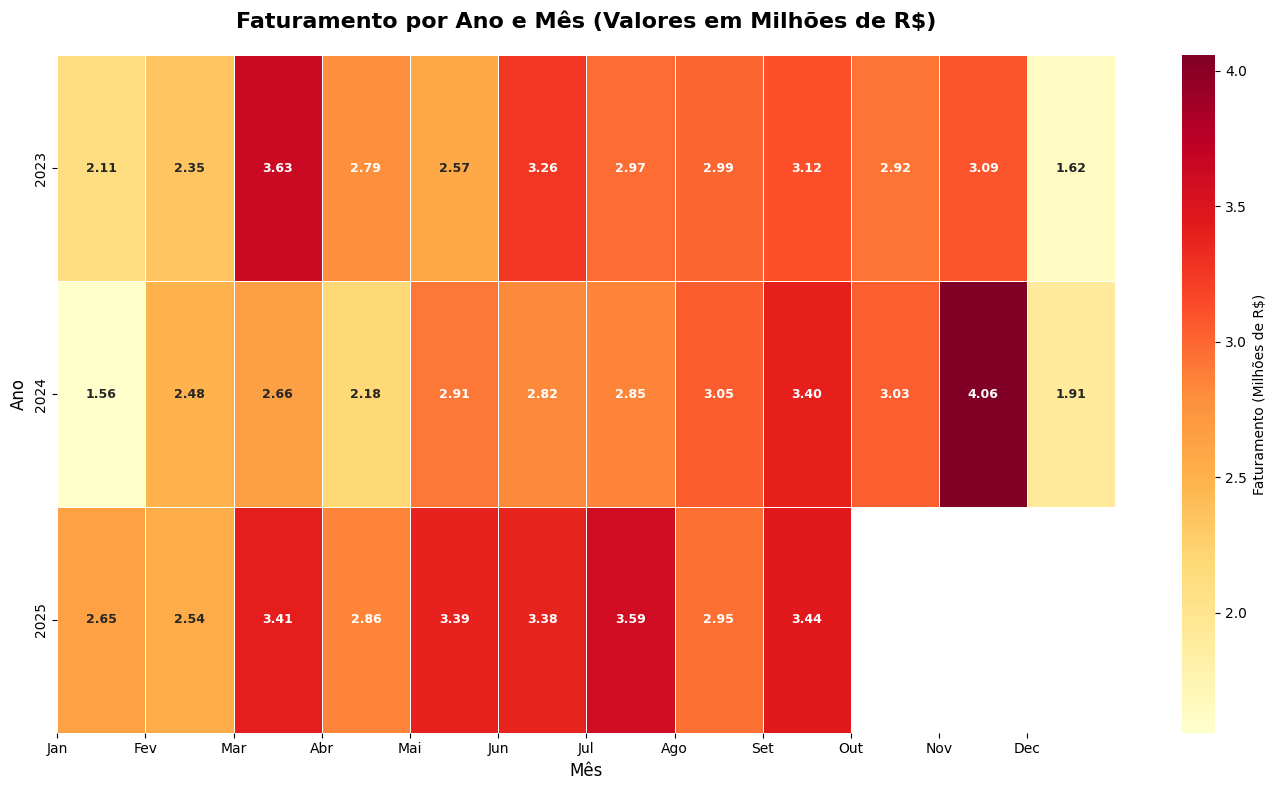

📊 TABELA DE FATURAMENTO (EM MILHÕES DE R$):
mes     1     2     3     4     5     6     7     8     9     10    11    12
ano                                                                         
2023  2.11  2.35  3.63  2.79  2.57  3.26  2.97  2.99  3.12  2.92  3.09  1.62
2024  1.56  2.48  2.66  2.18  2.91  2.82  2.85  3.05  3.40  3.03  4.06  1.91
2025  2.65  2.54  3.41  2.86  3.39  3.38  3.59  2.95  3.44   NaN   NaN   NaN


In [10]:
df_heatmap = df_mensal
df_heatmap.set_index('data', inplace=True)
df_heatmap['ano'] = df_heatmap.index.year
df_heatmap['mes'] = df_heatmap.index.month


pivot_table = df_heatmap.pivot_table(values='faturamento',
                            index='ano',
                            columns='mes',
                            aggfunc='sum')


pivot_table_display = pivot_table / 1e6


nomes_meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
               'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dec']

plt.figure(figsize=(14, 8))


heatmap = sns.heatmap(pivot_table_display,
                      annot=True,
                      fmt='.2f',  # 1 casa decimal
                      cmap='YlOrRd',
                      cbar_kws={'label': 'Faturamento (Milhões de R$)'},
                      linewidths=0.5,
                      annot_kws={'size': 9, 'weight': 'bold'})

plt.title('Faturamento por Ano e Mês (Valores em Milhões de R$)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Ano', fontsize=12)


plt.xticks(ticks=range(12), labels=nomes_meses, rotation=0)

plt.tight_layout()
plt.show()


print("📊 TABELA DE FATURAMENTO (EM MILHÕES DE R$):")
print("=" * 60)
print(pivot_table_display.round(2))

<Figure size 1200x600 with 0 Axes>

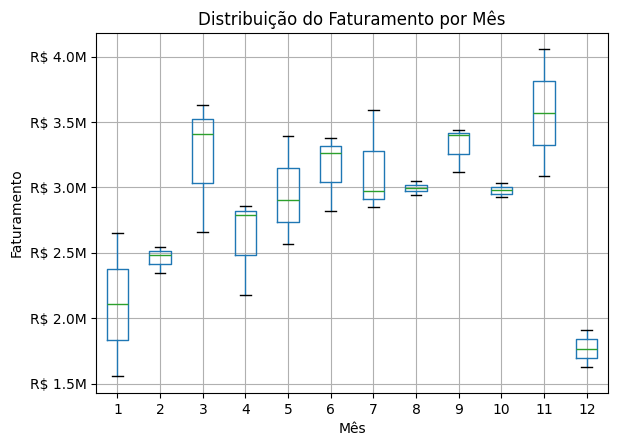

In [11]:
df_mensal['mes'] = df_mensal.index.month

plt.figure(figsize=(12,6))

ax = df_mensal.boxplot(column='faturamento', by='mes')

def format_reais(x, pos):
    if x >= 1e6:
        return f'R$ {x/1e6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x/1e3:.0f}K'
    else:
        return f'R$ {x:.0f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_reais))

plt.title('Distribuição do Faturamento por Mês')
plt.suptitle('')
plt.xlabel('Mês')
plt.ylabel('Faturamento')
plt.show()

In [12]:
resultado = adfuller(df_mensal['faturamento'])
print(f'Estatística ADF: {resultado[0]}')
print(f'p-valor: {resultado[1]}')

if resultado[1] < 0.05:
    print('✅ Série estacionária (rejeita H0)')
else:
    print('⚠️ Série NÃO estacionária (não rejeita H0)')


Estatística ADF: -4.484155831897449
p-valor: 0.0002100169892955854
✅ Série estacionária (rejeita H0)


In [13]:
df_mm = df_mensal
df_mm['ano'] = df_mm.index.year
df_mm['mes'] = df_mm.index.month


faturamento_medio_mensal = df_mensal.groupby('mes')['faturamento'].mean()


faturamento_anual = df_mensal.groupby('ano')['faturamento'].sum()

print("Faturamento médio por mês:")
print(faturamento_medio_mensal)

print("\nFaturamento anual:")
print(faturamento_anual)

Faturamento médio por mês:
mes
1     2.103952e+06
2     2.457948e+06
3     3.233160e+06
4     2.608922e+06
5     2.955696e+06
6     3.153431e+06
7     3.137072e+06
8     2.994869e+06
9     3.318091e+06
10    2.979165e+06
11    3.571613e+06
12    1.767375e+06
Name: faturamento, dtype: float64

Faturamento anual:
ano
2023    3.341623e+07
2024    3.290926e+07
2025    2.820025e+07
Name: faturamento, dtype: float64


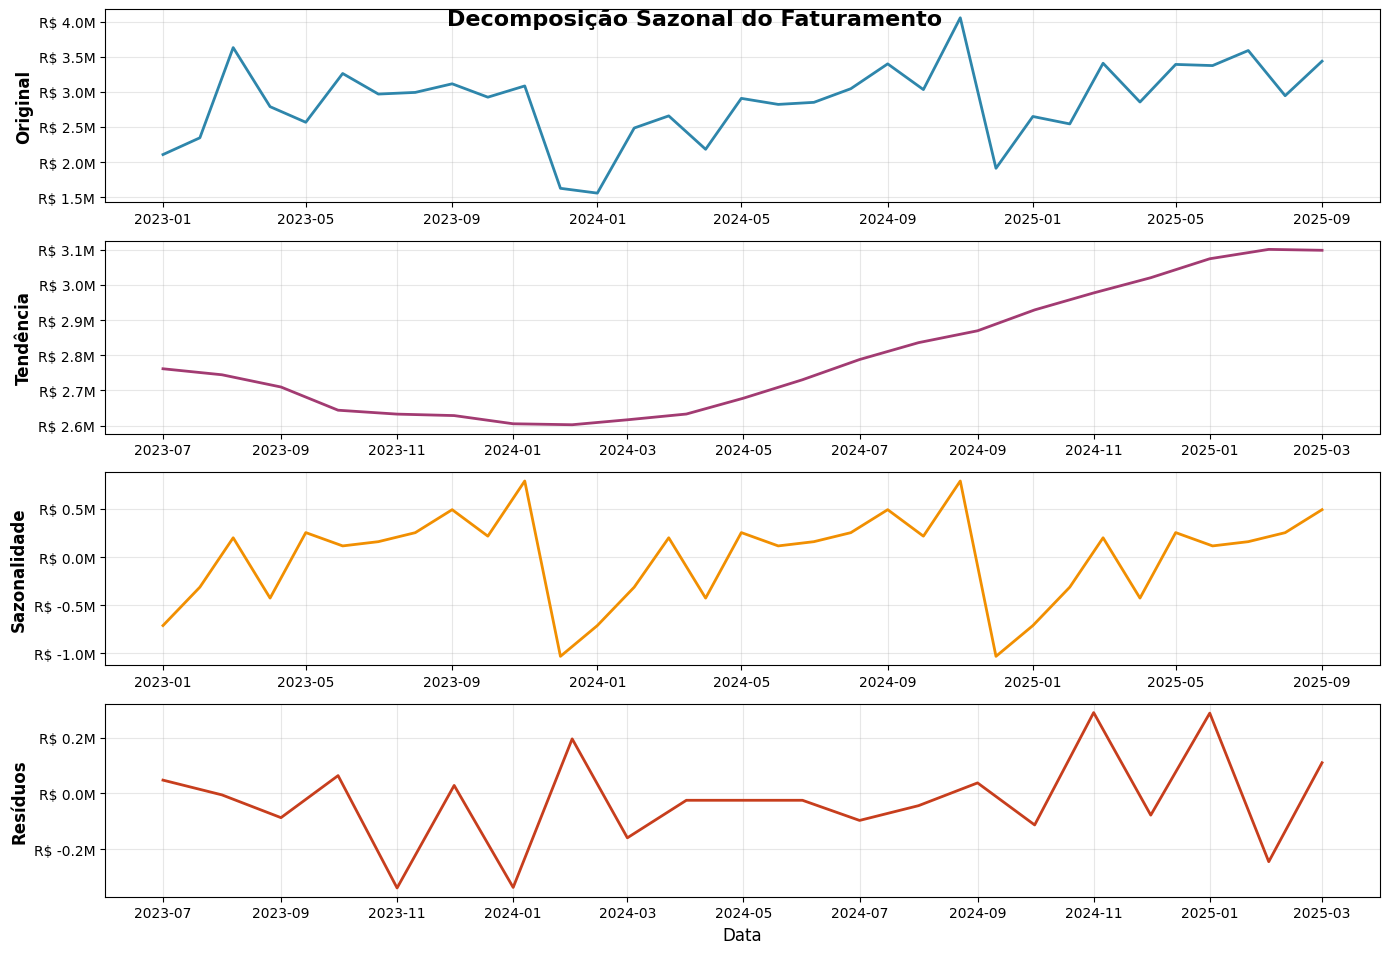

In [14]:
df_monthly = df_mensal.asfreq('MS')
decomposition = seasonal_decompose(df_monthly['faturamento'], model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
fig.suptitle('Decomposição Sazonal do Faturamento', fontsize=16, fontweight='bold', y=0.95)


def format_reais(x, pos):
    return f'R$ {x/1e6:.1f}M'


for ax in axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_reais))
    ax.grid(True, alpha=0.3)


axes[0].plot(decomposition.observed, color='#2E86AB', linewidth=2)
axes[0].set_ylabel('Original', fontsize=12, fontweight='bold')


axes[1].plot(decomposition.trend, color='#A23B72', linewidth=2)
axes[1].set_ylabel('Tendência', fontsize=12, fontweight='bold')


axes[2].plot(decomposition.seasonal, color='#F18F01', linewidth=2)
axes[2].set_ylabel('Sazonalidade', fontsize=12, fontweight='bold')


axes[3].plot(decomposition.resid, color='#C73E1D', linewidth=2)
axes[3].set_ylabel('Resíduos', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Data', fontsize=12)

plt.tight_layout()
plt.show()

In [15]:

model = SARIMAX(train['faturamento'],
                order=(1,1,1),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

In [16]:
forecast_val = results.get_forecast(steps=len(val))
val_pred = forecast_val.predicted_mean

In [17]:
mae = mean_absolute_error(val['faturamento'], val_pred)
rmse = np.sqrt(mean_squared_error(val['faturamento'], val_pred))
print(f"Validação - MAE: {mae} | RMSE: {rmse}")

Validação - MAE: 8065863783.832624 | RMSE: 16183906905.389421


In [18]:

# from statsmodels.tsa.holtwinters import ExponentialSmoothing


# df_soo = df_mensal.sort_values('data')

# ultimo_mes = df.index[-1]

# model = ExponentialSmoothing(
#     df_soo['faturamento'],
#     trend='add',
#     seasonal=None
# ).fit()


# future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1),
#                              periods=3, freq='MS')
# forecast_df = pd.DataFrame({'data': future_dates, 'previsao': forecast.values})

# print("📅 Previsão para os próximos 3 meses:")
# print(forecast_df)


O modelo Exponential Smoothing (Holt-Winters), sem sazonalidade, mostrou precisão e estabilidade dentro do curto histórico (33 pontos, dados mensais). Deveremos ter mais dados para prever um ano

In [19]:
historico = df.copy()
previsoes = []
reais = []

# Simula previsões de 1 passo à frente a partir do 24º mês
for i in range(24, len(historico)):
    train = historico.iloc[:i]
    real = historico.iloc[i]['faturamento']

    model = ExponentialSmoothing(train['faturamento'],
                                 trend='add',
                                 seasonal=None).fit()
    prev = model.forecast(1).iloc[0]

    previsoes.append(prev)
    reais.append(real)

mae = mean_absolute_error(reais, previsoes)
rmse = np.sqrt(mean_squared_error(reais, previsoes))

reais_ = np.array(reais)
previsoes_ = np.array(previsoes)
mape = np.mean( np.abs(reais_ - previsoes_)/reais_) * 100
print(f"Rolling Forecast -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}%")


Rolling Forecast -> MAE: 335,203.25 | RMSE: 354,493.78 | MAPE: 10.65%


| Indicador                                | Valor               | Interpretação                                                                                    |
| ---------------------------------------- | ------------------- | ------------------------------------------------------------------------------------------------ |
| **Previsão (Próximo mês)**               | R$ **3.430.630,85** | Mantém o padrão estável da série, coerente com os meses recentes                                 |
| **MAE (Erro médio absoluto)**            | R$ **336.085,87**   | O erro médio das previsões é cerca de **10% do faturamento mensal** — desempenho considerado bom |
| **RMSE (Raiz do erro quadrático médio)** | R$ **375.971,46**   | Indica **baixa variação dos erros**, sem desvios extremos                                        |
| **Estacionariedade (ADF Test)**          | p-valor < 0.001     | A série é estacionária, o que favorece modelos lineares como Holt-Winters                        |


## Gerar gráfico

In [20]:
def rolling_forecast_eval(historico, coluna_valor, periodo_inicial, horizonte=1):
    """
    Realiza a validação Walk-Forward (Rolling Forecast) e avalia o desempenho.

    :param historico: DataFrame contendo a série temporal.
    :param coluna_valor: Nome da coluna que contém os valores a serem previstos (ex: 'faturamento').
    :param periodo_inicial: Número mínimo de observações para o primeiro treinamento.
    :param horizonte: Número de passos à frente para a previsão (h). Padrão é 1.
    :return: Dicionário com métricas e DataFrame com resultados de previsão.
    """

    if periodo_inicial >= len(historico):
        raise ValueError("O período inicial deve ser menor que o tamanho do histórico.")

    previsoes = []
    reais = []
    indices_previstos = []

    # O loop começa no ponto onde o conjunto de treinamento é válido
    # E avança até que a última previsão possa ser feita
    for i in range(periodo_inicial, len(historico) - horizonte + 1):
        
        # 1. Definir Treinamento e Real
        train = historico.iloc[:i]
        
        # O valor real é o valor 'h' passos à frente do final do treino
        real_slice = historico.iloc[i : i + horizonte]
        
        # 2. Treinar o Modelo (Ajuste do ExponentialSmoothing)
        try:
            model = ExponentialSmoothing(
                train[coluna_valor],
                trend='add',
                seasonal=None
            ).fit()
            
            # 3. Gerar a Previsão
            # forecast(h) retorna h previsões
            previsao_h = model.forecast(horizonte)
            
            previsoes.extend(previsao_h.tolist())
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

        except Exception as e:
            print(f"Erro ao ajustar o modelo no índice {i}: {e}")
            # Se der erro, preenche com NaN para manter o comprimento
            previsoes.extend([np.nan] * horizonte)
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())


    # --- 4. Avaliação das Métricas (apenas nos valores não NaN) ---
    
    df_resultados = pd.DataFrame({
        'data': indices_previstos,
        'real': reais,
        'previsao': previsoes
    }).set_index('data').dropna()
    
    if df_resultados.empty:
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan}, df_resultados
        
    reais_ = df_resultados['real'].values
    previsoes_ = df_resultados['previsao'].values

    mae = mean_absolute_error(reais_, previsoes_)
    rmse = np.sqrt(mean_squared_error(reais_, previsoes_))
    
    # Cálculo do MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs(reais_ - previsoes_) / np.abs(reais_)) * 100

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

    print(f"Rolling Forecast (h={horizonte}) -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}%")
    
    return metrics, df_resultados

In [21]:
coluna = 'faturamento'
periodo_treino_minimo = 24
horizonte_previsao = 3

In [22]:
metricas, df_resultados = rolling_forecast_eval(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao
)

Rolling Forecast (h=3) -> MAE: 349,031.63 | RMSE: 376,545.72 | MAPE: 10.81%


In [23]:
metricas

{'MAE': 349031.625136594,
 'RMSE': np.float64(376545.71516192314),
 'MAPE': np.float64(10.805156599426235)}

In [24]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [25]:
def format_currency_millions(x, pos):
    """Função para formatar valores do eixo Y como R$ X.X M."""
    if x >= 1e6:
        return f'R$ {x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x*1e-3:.1f}K'
    else:
        return f'R$ {x:,.0f}'

In [26]:
def format_currency_annotation(value):
    """Função para formatar valores em anotações (ex: R$ 33.4M)."""
    if value >= 1e6:
        return f'R$ {value*1e-6:.1f}M'
    else:
        return f'R$ {value:,.0f}'

In [27]:
def plot_forecast_results(historico_completo, df_resultados, coluna_valor, metricas, titulo="Série Temporal e Previsões"):
    """
    Gera um gráfico Matplotlib comparando Real vs. Previsto do Rolling Forecast
    """
    
    # 1. Preparação dos Dados
    
    # Historico completo (série de valores reais)
    df_real = historico_completo.reset_index()
    df_real.columns = ['data', 'valor_real']

    # DataFrame de Previsões (apenas onde o forecast foi calculado)
    df_previsto = df_resultados.reset_index()
    df_previsto.columns = ['data', 'valor_real_previsto', 'previsao']
    
    
    # 2. Configuração do Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- 3. Plotagem do Valor Real ---
    ax.plot(
        df_real['data'], 
        df_real['valor_real'], 
        label=f'{coluna_valor.capitalize()} Real',
        marker='o', 
        linestyle='-', 
        color='C0'
    )

    # --- 4. Plotagem da Previsão ---
    # Plota a previsão a partir do primeiro ponto previsto
    ax.plot(
        df_previsto['data'], 
        df_previsto['previsao'], 
        label=f'{coluna_valor.capitalize()} Previsto',
        marker='o', 
        linestyle='--', # Linha tracejada para diferenciar
        color='red' 
    )
    
    # --- 5. Formatação dos Eixos ---
    
    # Eixo X (Datas)
    ax.set_xlabel("Data", fontsize=12)
    
    # Formatação de data (ajustar conforme a granularidade dos seus dados)
    # Se for mensal, podemos formatar como 'AAAA-MM'
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    
    # Eixo Y (Valores)
    ax.set_ylabel(coluna_valor.capitalize(), fontsize=12)
    formatter = mtick.FuncFormatter(format_currency_millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Título e Legendas
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)

    # Formatação do texto da métrica
    metrics_text = (
        f"Métricas de Erro:\n"
        f"MAE: {metricas.get('MAE', 0):,.2f}\n"
        f"RMSE: {metricas.get('RMSE', 0):,.2f}\n"
        f"MAPE: {metricas.get('MAPE', 0):,.2f}%"
    )
    
    # Adicionar o texto como um 'bbox' (bounding box) para destaque
    ax.text(
        0.98, 0.95, 
        metrics_text, 
        transform=ax.transAxes, # Usa coordenadas relativas (0 a 1)
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6, edgecolor='black')
    )
    
    plt.tight_layout()
    plt.show()

In [28]:
metricas, df_resultados = rolling_forecast_eval(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1
)

Rolling Forecast (h=1) -> MAE: 335,203.25 | RMSE: 354,493.78 | MAPE: 10.65%


In [29]:
metricas_, df_resultados_ = rolling_forecast_eval(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao
)

Rolling Forecast (h=3) -> MAE: 349,031.63 | RMSE: 376,545.72 | MAPE: 10.81%


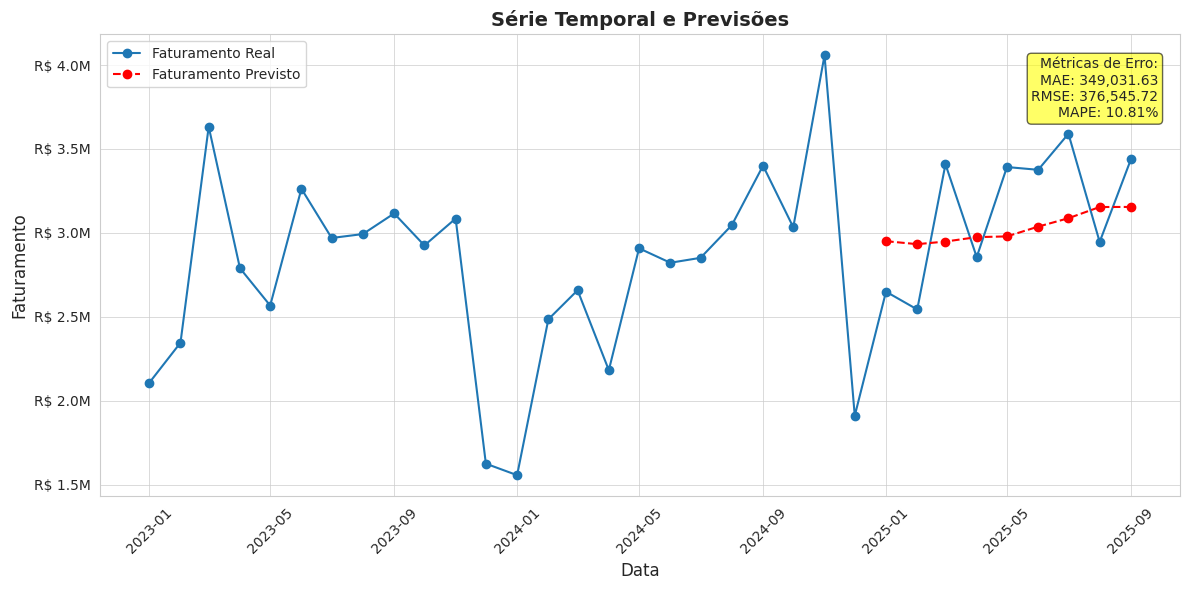

In [30]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados,
    coluna,
    metricas_
)